In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm
import pandas as pd

import constants as k
import utils

In [2]:
data_dir = '/Users/rebekahzhang/data/neural_data'
pickle_dir = Path(os.path.join(data_dir, 'session_pickles'))
figure_folder = os.path.join(data_dir, 'figures')

In [4]:
session_log = pd.read_csv(os.path.join(data_dir, 'sessions_vetted.csv'), index_col=0).sort_values('id')

In [5]:
session_log

,date,mouse,insertion_number,region,potential problems,sorting notes,First_X_Column,datetime,paramset_idx,num_units,id,length,num_trials,num_missed,wait_length_mean
0,2024-07-13,RZ034,1,str,NaN,should be all good now,Done,2024-07-13 12:58:26,101,47,RZ034_2024-07-13_str,2443.503482,328,0,3.317166
1,2024-07-14,RZ034,1,str,NaN,NaN,Done,2024-07-14 12:52:46,101,31,RZ034_2024-07-14_str,2832.875992,408,0,2.804475
2,2024-07-12,RZ036,1,str,NaN,NaN,Done,2024-07-12 12:50:31,101,45,RZ036_2024-07-12_str,3274.883860,299,3,6.628682
3,2024-07-12,RZ036,0,v1,NaN,NaN,Done,2024-07-12 12:50:31,101,19,RZ036_2024-07-12_v1,3274.883860,299,3,6.628682
4,2024-07-13,RZ036,1,str,NaN,NaN,Done,2024-07-13 14:29:03,101,35,RZ036_2024-07-13_str,4400.303239,295,15,10.838219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2025-02-21,RZ065,0,v1,NaN,"no bug, new phy",Done,2025-02-21 11:15:15,101,31,RZ065_2025-02-21_v1,3731.853914,302,0,3.075755
73,2025-02-14,RZ068,0,str,NaN,"no bug, new phy",Done,2025-02-14 13:29:40,101,6,RZ068_2025-02-14_str,2673.062209,157,6,6.795644
74,2025-02-12,RZ070,0,v1,pump wasnt properly grounded,"no bug, new phy",Done,2025-02-12 14:02:10,101,13,RZ070_2025-02-12_v1,2359.005391,360,0,2.217282
75,2025-02-13,RZ070,0,v1,NaN,"no bug, new phy",Done,2025-02-13 11:40:15,101,8,RZ070_2025-02-13_v1,2115.197888,327,0,2.087204


In [7]:
def get_data_for_debugging(filename = "RZ038_2024-07-19_str", unit_idx=16):
    events, trials, units = utils.get_session_data(filename, pickle_dir)
    spikes = units[unit_idx]
    return events, trials, spikes

events, trials, spikes = get_data_for_debugging()

### raster plot

In [8]:
def prepare_data_for_raster(events, trials, spikes):
    sorted_trial_id = trials.sort_values(by=['missed','rewarded','wait_length']).trial_id.tolist()
    events_raster = events.groupby('trial_id')
    spikes_raster = spikes.groupby('trial_id')
    return events_raster, spikes_raster, sorted_trial_id

def plot_raster(ax, sorted_trial_id, events_raster, spikes_raster, anchor, anchored_periods, show_legend=True):
    ax.axvline(0, color='tab:gray', linestyle='--', alpha=0.5, label=anchor)

    event_colors = {
        'visual': 'g',
        'wait': 'orange', 
        'cons_reward': 'b', 
        'cons_no_reward': 'r'
    }

    for trial_offset, t in enumerate(sorted_trial_id):
        # Plot trial events
        trial_events = events_raster.get_group(t)
        for event_type, color in event_colors.items():
            event_time = trial_events.loc[trial_events['event_type'] == event_type, anchor]
            ax.eventplot(
                event_time, lineoffsets=trial_offset, color=color, 
                linelengths=1.0, linewidths=0.8, alpha=1
            )

        if t in spikes_raster.groups:
            trial_spikes = spikes_raster.get_group(t)
            relevant_periods = anchored_periods[anchor]
            relevant_spike_times = trial_spikes.loc[trial_spikes.period.isin(relevant_periods), anchor]
            # Plot spikes (black)
            ax.eventplot(
                relevant_spike_times, 
                lineoffsets=trial_offset, 
                color='k', 
                linelengths=0.8, 
                linewidths=0.4
            )
            irrelevant_spike_times = trial_spikes.loc[~trial_spikes.period.isin(relevant_periods), anchor]
            ax.eventplot(
                irrelevant_spike_times, 
                lineoffsets=trial_offset, 
                color='darkgrey', 
                linelengths=0.8, 
                linewidths=0.4
            )
        else:
            continue
    # Create legend only for the last raster plot
    if show_legend:
        handles = [plt.Line2D([0], [0], color=c, lw=2, label=label) 
                   for label, c in event_colors.items()]
        ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.92))

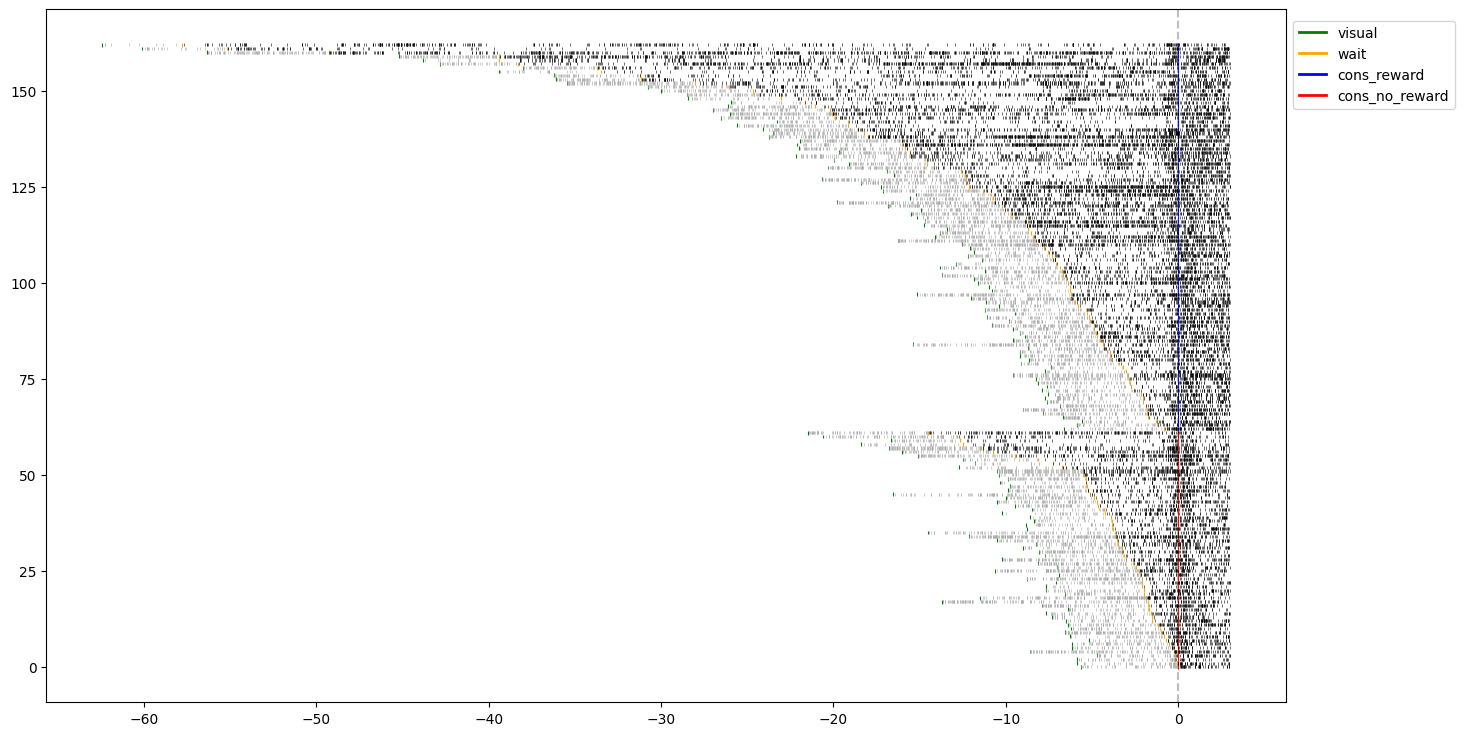

In [10]:
anchor = k.TO_DECISION
_, ax = plt.subplots(figsize=(16,9))
events_raster, spikes_raster, sorted_trial_id = prepare_data_for_raster(events, trials, spikes)
plot_raster(ax, sorted_trial_id, events_raster, spikes_raster, anchor, k.ANCHORED_PERIODS)

### histo plot

In [11]:
def prepare_data_for_histogram(trials, spikes, anchor, anchored_periods):
    # Calculate the aligned start and end time based on the anchor
    if anchor == k.TO_CUE_ON:
        # boundaries: trial start (0) -> cue off time
        trials['aligned_start_time'] = 0 - trials["cue_on_time"]
        trials['aligned_end_time'] = trials['cue_off_time'] - trials["cue_on_time"]
    
    elif anchor == k.TO_CUE_OFF:
        # boundaries: cue on time -> consumption time (or trial_length if consumption is missing)
        trials['aligned_start_time'] = trials['cue_on_time'] - trials["cue_off_time"]
        # Handle missing decision_time
        mask = trials['decision_time'].isna()
        trials.loc[~mask, 'aligned_end_time'] = trials['decision_time'] - trials["cue_off_time"]
        trials.loc[mask, 'aligned_end_time'] = trials['trial_length'] - trials["cue_off_time"]
    
    elif anchor == k.TO_DECISION:
        # boundaries: cue off time -> trial end
        trials['aligned_start_time'] = trials["cue_off_time"] - trials["decision_time"]
        trials['aligned_end_time'] = trials['trial_length'] - trials["decision_time"]

    relevant_periods = anchored_periods[anchor]
    spikes_histo = spikes.loc[spikes.period.isin(relevant_periods)].copy()
    
    # Filter trials with spikes
    trials_with_spikes = spikes_histo['trial_id'].unique()
    trials_histo = trials[trials['trial_id'].isin(trials_with_spikes)].copy()
    return trials_histo, spikes_histo

In [12]:
def generate_time_frame(trials, time_step, trial_count_mask=1):
    """
    Generate time bins and active trial counts.
    """
    # Calculate bounds (with protection against empty data)
    if len(trials) == 0:
        return np.array([]), np.array([]), np.array([])
        
    bounds = (
        np.round(trials.aligned_start_time.min(), decimals=1),
        np.round(trials.aligned_end_time.max(), decimals=1)
    )
    
    # Create bins
    bin_edges = np.arange(
        bounds[0] - time_step,
        bounds[1] + 2*time_step,
        time_step
    )
    bin_centers = bin_edges[:-1] + time_step/2
    
    # Calculate active trials
    active_trials = np.zeros(len(bin_edges) - 1, dtype=int)
    for _, trial in trials.iterrows():
        occupied = (bin_edges[:-1] < trial['aligned_end_time']) & \
                  (bin_edges[1:] > trial['aligned_start_time'])
        active_trials[occupied] += 1

    # Apply mask with safety checks
    if trial_count_mask > 0:
        valid_mask = active_trials >= trial_count_mask
        if not np.any(valid_mask):  # No valid bins
            return np.array([]), np.array([]), np.array([])
            
        bin_edges = np.append(
            bin_edges[:-1][valid_mask],
            bin_edges[:-1][valid_mask][-1] + time_step
        )
        bin_centers = bin_centers[valid_mask]
        active_trials = active_trials[valid_mask]
        
    return bin_edges, bin_centers, active_trials

In [13]:
def calculate_firing_rates(trials, spikes, anchor, time_step, trial_count_mask=5, sigma=0.01):
    bin_edges, bin_centers, active_trials = generate_time_frame(trials, time_step, trial_count_mask)
    
    # Handle case where no bins meet criteria
    if len(bin_edges) == 0:
        return np.array([]), np.array([]), np.array([])

    # Bin spikes for each trial, shape is [trial, bin]
    counts = np.array([
        np.histogram(trial[anchor], bins=bin_edges)[0]
        for _, trial in spikes.groupby('trial_id')
    ])
    rates = counts / time_step

    mean_fr = np.nansum(rates, axis=0) / active_trials
    sem_fr = np.std(rates, axis=0) / np.sqrt(active_trials)

    if sigma > 0:
        mean_fr = gaussian_filter1d(mean_fr, sigma=sigma)
        sem_fr = gaussian_filter1d(sem_fr, sigma=sigma)

    return bin_centers, mean_fr, sem_fr

In [14]:
def plot_firing_rates(ax, trials, spikes, anchor, time_step, sigma, trial_count_mask, show_legend=True):
    """Plots firing rates on given axes with legend on the right."""
    ax.axvline(0, color='tab:gray', linestyle='--', alpha=0.5, label=anchor)
    
    # Calculate rates for all trials
    bin_centers, mean_fr, sem_fr = calculate_firing_rates(
        trials, spikes, anchor, time_step, trial_count_mask, sigma
    )
    if len(bin_centers) > 0:
        ax.plot(bin_centers, mean_fr, 'k-', lw=1.5, alpha=0.8, label='All trials')
        ax.fill_between(bin_centers, mean_fr-sem_fr, mean_fr+sem_fr, color='gray', alpha=0.4)

    # Calculate and plot rates for three categories
    # Missed trials (missed=True)
    if anchor != k.TO_DECISION:
        trials_missed = trials.loc[trials.missed == True]
        spikes_missed = spikes.loc[spikes.trial_id.isin(trials_missed.trial_id)]
        bin_centers_m, mean_fr_m, sem_fr_m = calculate_firing_rates(
            trials_missed, spikes_missed, anchor, time_step, trial_count_mask, sigma
        )
        if len(bin_centers_m) > 0:
            ax.plot(bin_centers_m, mean_fr_m, color='#FFA500', linestyle='-', lw=1, alpha=0.8, label='Missed')
            ax.fill_between(bin_centers_m, mean_fr_m-sem_fr_m, mean_fr_m+sem_fr_m, color='#FFA500', alpha=0.3)
    
    # Non-missed unrewarded trials (missed=False and rewarded=False)
    trials_unrewarded = trials.loc[(trials.missed == False) & (trials.rewarded == False)]
    spikes_unrewarded = spikes.loc[spikes.trial_id.isin(trials_unrewarded.trial_id)]
    bin_centers_u, mean_fr_u, sem_fr_u = calculate_firing_rates(
        trials_unrewarded, spikes_unrewarded, anchor, time_step, trial_count_mask, sigma
    )
    if len(bin_centers_u) > 0:
        ax.plot(bin_centers_u, mean_fr_u, 'r-', lw=1, alpha=0.8, label='Unrewarded')
        ax.fill_between(bin_centers_u, mean_fr_u-sem_fr_u, mean_fr_u+sem_fr_u, color='r', alpha=0.3)
    
    # Rewarded trials (missed=False and rewarded=True)
    trials_rewarded = trials.loc[(trials.missed == False) & (trials.rewarded == True)]
    spikes_rewarded = spikes.loc[spikes.trial_id.isin(trials_rewarded.trial_id)]
    bin_centers_r, mean_fr_r, sem_fr_r = calculate_firing_rates(
        trials_rewarded, spikes_rewarded, anchor, time_step, trial_count_mask, sigma
    )
    if len(bin_centers_r) > 0:
        ax.plot(bin_centers_r, mean_fr_r, 'b-', lw=1, alpha=0.8, label='Rewarded')
        ax.fill_between(bin_centers_r, mean_fr_r-sem_fr_r, mean_fr_r+sem_fr_r, color='b', alpha=0.3)

    # Add the firing rate legend to the right of the plot
    if show_legend:
        ax.legend(bbox_to_anchor=(1, 1.05), loc='upper left')

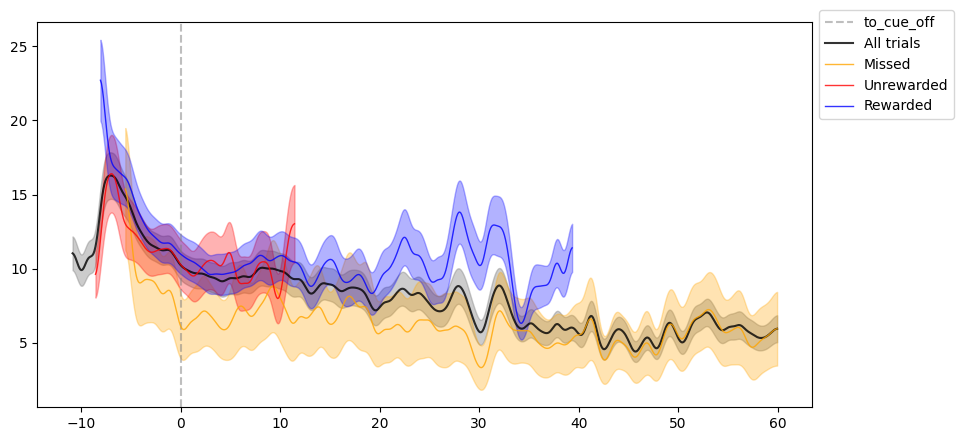

In [16]:
anchor = k.TO_CUE_OFF
time_step = 0.1
sigma = 5
trial_count_mask = 5

trials_histo, spikes_histo = prepare_data_for_histogram(trials, spikes, anchor, k.ANCHORED_PERIODS)
_, ax = plt.subplots(figsize=(10, 5))
plot_firing_rates(ax, trials_histo, spikes_histo, anchor, time_step, sigma, trial_count_mask)

### combined

In [17]:
def plot_raster_histo_with_3_anchors(unit_id, events, trials, spikes, sorted_trial_id, 
                                     anchored_periods, time_step, sigma, trial_count_mask, 
                                     save_fig=False, figure_folder=figure_folder, regenerate=False):
    fig, axes = plt.subplots(
        2, 3, figsize=(16, 9),  
        sharex='col', sharey='row',
        gridspec_kw={'height_ratios': [3, 1]}
    )
    plt.subplots_adjust(right=0.85)

    for i, anchor in enumerate(anchored_periods.keys()):
        ax_raster = axes[0, i]
        ax_rate = axes[1, i]

        events_raster, spikes_raster, sorted_trial_id = prepare_data_for_raster(events, trials, spikes)
        plot_raster(ax_raster, sorted_trial_id, events_raster, spikes_raster, 
                    anchor, anchored_periods,show_legend=(i==2))

        trials_histo, spikes_histo = prepare_data_for_histogram(trials, spikes, anchor, anchored_periods)
        plot_firing_rates(ax_rate, trials_histo, spikes_histo, anchor, 
                         time_step, sigma, trial_count_mask, show_legend=(i==2))

        ax_raster.set_title(f"Aligned {anchor}")
        if i == 0:
            ax_raster.set_ylabel("Trial #")
            ax_rate.set_ylabel("Firing Rate (Hz)")
        ax_rate.set_xlabel("Time (s)")

    plt.suptitle(unit_id)
    plt.tight_layout()

    if save_fig:
        fig_path = f'{figure_folder}/{unit_id}.png'
        if regenerate or not os.path.exists(fig_path):
            fig.savefig(fig_path, bbox_inches='tight', dpi=300, format='png')
        fig.clf()
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)

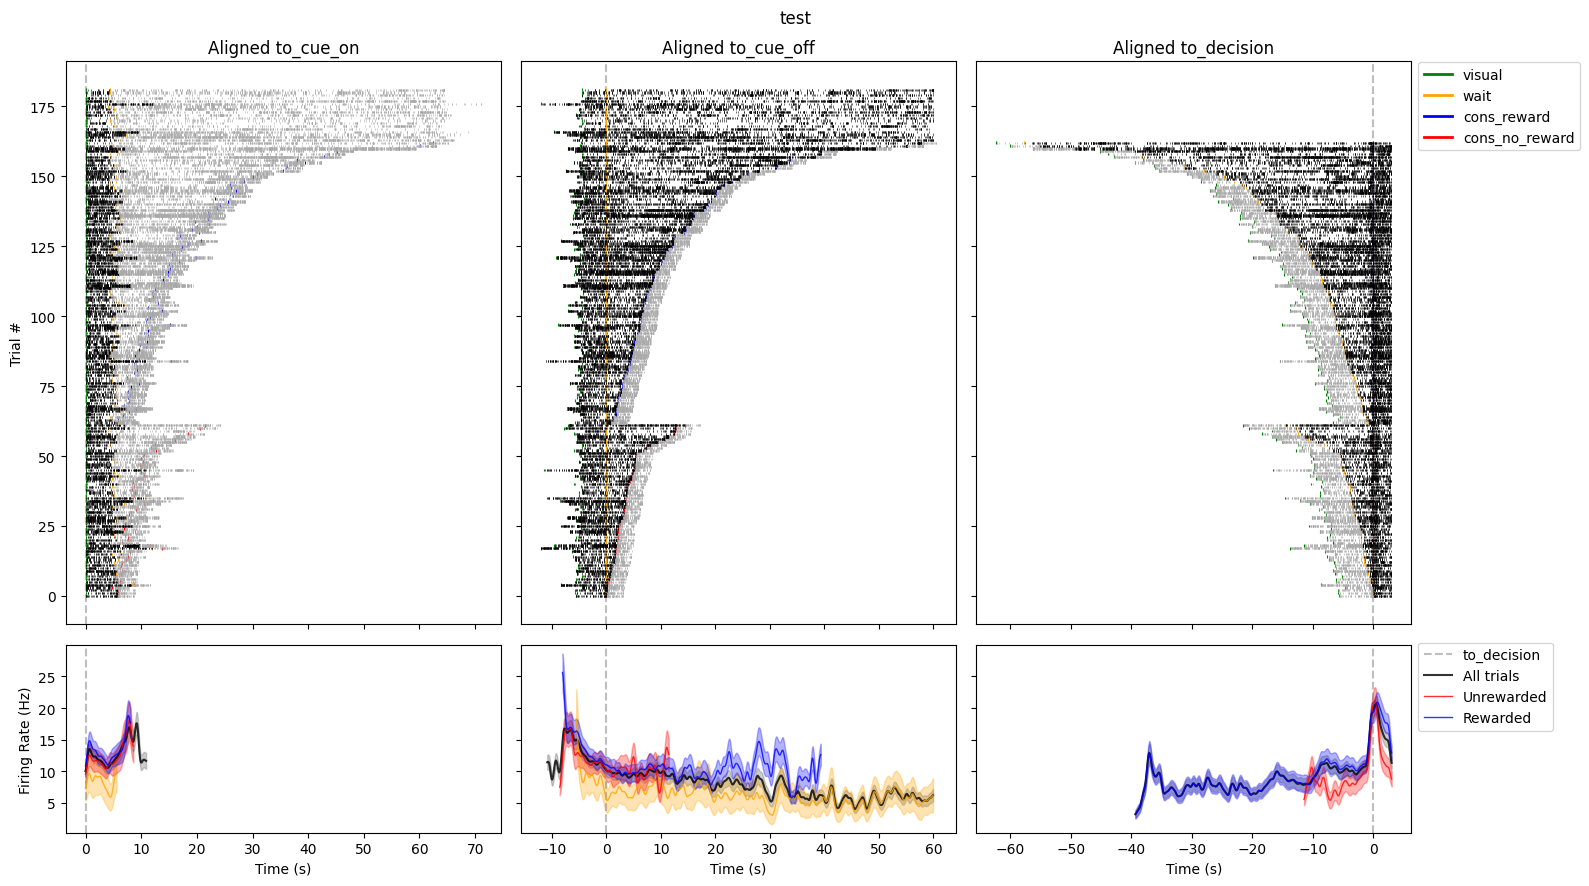

In [19]:
time_step = 0.1
sigma = 3
trial_count_mask = 5

plot_raster_histo_with_3_anchors("test", events, trials, spikes, sorted_trial_id, 
                                     k.ANCHORED_PERIODS, time_step, sigma, trial_count_mask, 
                                     save_fig=False, figure_folder=figure_folder, regenerate=True)

# Looping

In [18]:
time_step = 0.1
sigma = 3
trial_count_mask = 5
save_fig = True
raster_histo_folder = os.path.join(figure_folder, "raster_histo_v2")
regenerate = False

In [19]:
# test_log = session_log.loc[session_log.id=="RZ037_2024-07-16_v1"]

In [ ]:
failed_units = []

# Create progress bar for sessions
for i, session_info in tqdm(session_log.iterrows(), total=len(session_log), desc="Processing sessions"):
    session_id = session_info['id']
    filename = session_id + ".pkl"
    events, trials, units = utils.get_session_data(filename, pickle_dir)
    
    # Create nested progress bar for units within each session
    for i, spikes in tqdm(enumerate(units), total=len(units), desc=f"Session {session_id}", leave=False):
        unit_id = f"{session_id}-unit_{i}"
        figure_path = os.path.join(raster_histo_folder, f"{unit_id}.png")
        
        if os.path.exists(figure_path) and not regenerate:
            continue
            
        try:
            # Only call the plotting function if we need to generate/regenerate the figure
            plot_raster_histo_with_3_anchors(unit_id, events, trials, spikes, sorted_trial_id,
                                           k.anchored_periods, time_step, sigma, trial_count_mask,
                                           save_fig, raster_histo_folder, regenerate)
        except Exception as e:
            # Add the failed unit to our list
            failed_units.append({
                'unit_id': unit_id,
                'error': str(e)
            })
if failed_units:
    print(failed_units)
else:
    print("All units processed successfully!")

Processing sessions:   0%|          | 0/54 [00:00<?, ?it/s]

Session RZ034_2024-07-13_str:   0%|          | 0/47 [00:00<?, ?it/s]

Session RZ034_2024-07-13_v1:   0%|          | 0/1 [00:00<?, ?it/s]

Session RZ034_2024-07-14_str:   0%|          | 0/31 [00:00<?, ?it/s]

Session RZ036_2024-07-12_str:   0%|          | 0/45 [00:00<?, ?it/s]

Session RZ036_2024-07-12_v1:   0%|          | 0/19 [00:00<?, ?it/s]

Session RZ036_2024-07-13_str:   0%|          | 0/35 [00:00<?, ?it/s]

Session RZ036_2024-07-13_v1:   0%|          | 0/1 [00:00<?, ?it/s]

Session RZ036_2024-07-14_str:   0%|          | 0/34 [00:00<?, ?it/s]

Session RZ037_2024-07-16_str:   0%|          | 0/64 [00:00<?, ?it/s]

Session RZ037_2024-07-16_v1:   0%|          | 0/4 [00:00<?, ?it/s]

Session RZ037_2024-07-17_str:   0%|          | 0/61 [00:00<?, ?it/s]

Session RZ037_2024-07-18_str:   0%|          | 0/23 [00:00<?, ?it/s]

Session RZ037_2024-07-18_v1:   0%|          | 0/13 [00:00<?, ?it/s]

Session RZ038_2024-07-16_str:   0%|          | 0/101 [00:00<?, ?it/s]

Session RZ038_2024-07-17_str:   0%|          | 0/1 [00:00<?, ?it/s]

Session RZ038_2024-07-17_v1:   0%|          | 0/2 [00:00<?, ?it/s]

Session RZ038_2024-07-18_str:   0%|          | 0/32 [00:00<?, ?it/s]

Session RZ038_2024-07-19_str:   0%|          | 0/19 [00:00<?, ?it/s]

Session RZ039_2024-07-17_str:   0%|          | 0/17 [00:00<?, ?it/s]

Session RZ047_2024-11-19_str:   0%|          | 0/42 [00:00<?, ?it/s]

Session RZ047_2024-11-20_str:   0%|          | 0/92 [00:00<?, ?it/s]

Session RZ047_2024-11-20_v1:   0%|          | 0/55 [00:00<?, ?it/s]

Session RZ047_2024-11-21_str:   0%|          | 0/16 [00:00<?, ?it/s]

Session RZ047_2024-11-21_v1:   0%|          | 0/4 [00:00<?, ?it/s]

Session RZ047_2024-11-22_str:   0%|          | 0/26 [00:00<?, ?it/s]

Session RZ047_2024-11-22_v1:   0%|          | 0/13 [00:00<?, ?it/s]

Session RZ049_2024-10-29_str:   0%|          | 0/16 [00:00<?, ?it/s]

Session RZ049_2024-10-29_v1:   0%|          | 0/23 [00:00<?, ?it/s]

Session RZ049_2024-10-30_str:   0%|          | 0/14 [00:00<?, ?it/s]

Session RZ049_2024-10-30_v1:   0%|          | 0/1 [00:00<?, ?it/s]

Session RZ049_2024-11-01_str:   0%|          | 0/3 [00:00<?, ?it/s]

Session RZ050_2024-11-19_v1:   0%|          | 0/20 [00:00<?, ?it/s]

Session RZ050_2024-11-20_str:   0%|          | 0/113 [00:00<?, ?it/s]

Session RZ050_2024-11-20_v1:   0%|          | 0/7 [00:00<?, ?it/s]

Session RZ050_2024-11-21_str:   0%|          | 0/58 [00:00<?, ?it/s]

Session RZ050_2024-11-21_v1:   0%|          | 0/11 [00:00<?, ?it/s]

Session RZ050_2024-11-22_str:   0%|          | 0/32 [00:00<?, ?it/s]

Session RZ050_2024-11-22_v1:   0%|          | 0/4 [00:00<?, ?it/s]

Session RZ051_2024-11-19_str:   0%|          | 0/35 [00:00<?, ?it/s]

Session RZ051_2024-11-19_v1:   0%|          | 0/1 [00:00<?, ?it/s]

Session RZ051_2024-11-20_str:   0%|          | 0/26 [00:00<?, ?it/s]

Session RZ051_2024-11-20_v1:   0%|          | 0/74 [00:00<?, ?it/s]

Session RZ051_2024-11-21_str:   0%|          | 0/14 [00:00<?, ?it/s]

Session RZ051_2024-11-21_v1:   0%|          | 0/3 [00:00<?, ?it/s]

Session RZ051_2024-11-22_str:   0%|          | 0/8 [00:00<?, ?it/s]

Session RZ051_2024-11-22_v1:   0%|          | 0/7 [00:00<?, ?it/s]

Session RZ052_2024-10-25_v1:   0%|          | 0/6 [00:00<?, ?it/s]

Session RZ053_2024-10-22_v1:   0%|          | 0/41 [00:00<?, ?it/s]

Session RZ053_2024-10-24_v1:   0%|          | 0/10 [00:00<?, ?it/s]

Session RZ053_2024-10-25_v1:   0%|          | 0/4 [00:00<?, ?it/s]

Session RZ055_2024-10-30_str:   0%|          | 0/6 [00:00<?, ?it/s]

Session RZ055_2024-10-30_v1:   0%|          | 0/17 [00:00<?, ?it/s]

Session RZ055_2024-10-31_str:   0%|          | 0/29 [00:00<?, ?it/s]

Session RZ055_2024-11-01_v1:   0%|          | 0/4 [00:00<?, ?it/s]

All units processed successfully!


: 